In [77]:
import rioxarray as rxr
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import date,datetime
import pandas as pd
import warnings
from tqdm import tqdm
import rasterio
warnings.filterwarnings("ignore")

In [4]:
raster_data = rxr.open_rasterio('Curah_Hujan.tif')
mask = raster_data != -9999

# Calculate the minimum value excluding -9999
min_value_ch = raster_data.where(mask).min()
max_value_ch = raster_data.where(mask).max()

In [5]:
raster_data = rxr.open_rasterio('RH.tif')
mask = raster_data != -9999

# Calculate the minimum value excluding -9999
min_value_rh = raster_data.where(mask).min()
max_value_rh = raster_data.where(mask).max()

In [6]:
raster_data = rxr.open_rasterio('TEMPERATUR.tif')
mask = raster_data != -9999

# Calculate the minimum value excluding -9999
min_value_t = raster_data.where(mask).min()
max_value_t = raster_data.where(mask).max()

In [7]:
def mosaic_monthly(raster_file,year):
    raster_data = rxr.open_rasterio(raster_file)
    date_a = date(2011, 1, 1)
    ar_year=[]
    for i in range(1,13):
        date_b = date(year, i, 1)
        if i<11:
            date_c = date(year, i+1, 1)
        else:
            date_c = date(year+1,1,1)
        days_start=(date_b - date_a).days
        days_end=(date_c-date_a).days
        bands=raster_data[range(days_start,days_end+1)]
        ar_months = np.array([band.values for band in bands])
        ar_year.append(ar_months.mean(axis=0))        
    return np.array(ar_year)

In [8]:
dict_ch={}
for i in tqdm(range(2011,2023)):
    ch_mosaic=mosaic_monthly('Curah_Hujan.tif',i)
    dict_ch[i]=ch_mosaic

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:55<00:00, 14.66s/it]


In [9]:
dict_rh={}
for i in tqdm(range(2011,2023)):
    rh_mosaic=mosaic_monthly('RH.tif',i)
    dict_rh[i]=ch_mosaic

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:44<00:00,  8.72s/it]


In [10]:
dict_t={}
for i in tqdm(range(2011,2023)):
    t_mosaic=mosaic_monthly('TEMPERATUR.tif',i)
    dict_t[i]=t_mosaic

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:55<00:00, 14.58s/it]


In [11]:
tif_path = 'NDVI_11_24_full.tif'
raster = rxr.open_rasterio(tif_path)
# Convert the raster data into a NumPy array
ndvi_mosaic = raster.values

tif_path = 'PDSI_11_24_full.tif'
raster = rxr.open_rasterio(tif_path)
# Convert the raster data into a NumPy array
pdsi_mosaic = raster.values

print(ndvi_mosaic.shape)

(163, 38, 50)


In [12]:
##get ndvi from 2018-2020 for calibration
def months_between(start_date, end_date):
  """Calculates the number of months between two dates."""
  diff = relativedelta(end_date, start_date)
  return diff.years * 12 + diff.months

start_date = datetime(2011, 1, 1)
end_date_a = datetime(2018, 1, 1)
end_date_b = datetime(2021, 1, 1)
months_a = months_between(start_date, end_date_a)
months_b = months_between(start_date, end_date_b)

In [13]:
ndvi_cal=ndvi_mosaic[months_a:months_b,:,:]
pdsi_cal=pdsi_mosaic[months_a:months_b,:,:]

In [14]:
ndvi_cal.shape

(36, 38, 50)

In [15]:
ch_cal=[]
rh_cal=[]
t_cal=[]
for i in [2018,2019,2020]:
    ch_cal.extend(dict_ch[i])
    rh_cal.extend(dict_rh[i])
    t_cal.extend(dict_t[i])
ch_cal=np.array(ch_cal)
rh_cal=np.array(rh_cal)
t_cal=np.array(t_cal)

In [16]:
ch_cal.shape

(36, 38, 50)

In [17]:
ndvi_cal.shape

(36, 38, 50)

In [19]:
dt_gab=np.array([ch_cal,rh_cal,t_cal,ndvi_cal,pdsi_cal])

In [20]:
dict_df={}
for i in range(0,dt_gab.shape[0]):
    dict_df[i]=dt_gab[i,:,:,:].ravel()

In [21]:
data_=pd.DataFrame(dict_df)
data_.columns=['ch','rh','t','ndvi','pdsi']

In [22]:
data_.describe()

,ch,rh,t,ndvi,pdsi
count,68400.000000,68400.000000,68400.000000,68400.000000,68400.000000
mean,-2873.774868,-2872.166159,-2860.660001,4061.369370,-25.371707
std,4530.507068,4531.529385,4538.843494,3209.697544,211.458858
min,-9999.000000,-9999.000000,-9999.000000,-596.171692,-666.798401
25%,-9999.000000,-9999.000000,-9999.000000,0.000000,-169.093826
50%,2.111723,5.740680,23.891897,5109.361816,0.000000
75%,8.646669,10.409944,26.499000,6980.412598,100.837158
max,71.198967,49.781847,31.230450,8960.260742,949.697388


In [23]:
data_['ndvi'].replace(0,-9999,inplace=True)
data_['ndvi'].replace(-9999,np.nan,inplace=True)
data_['pdsi'].replace(0,-9999,inplace=True)
data_['pdsi'].replace(-9999,np.nan,inplace=True)
data_['ch'].replace(-9999,np.nan,inplace=True)
data_['rh'].replace(-9999,np.nan,inplace=True)
data_['t'].replace(-9999,np.nan,inplace=True)

In [24]:
data_.dropna(inplace=True)

In [25]:
data_['ndvi']=data_.ndvi*0.0001
data_['pdsi']=data_.pdsi*0.01

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Matplotlib is building the font cache; this may take a moment.


In [27]:
data_['PCI']=data_.ch.apply(lambda y: (y-min_value_ch.values)/(max_value_ch.values-min_value_ch.values))
data_['TCI']=data_.rh.apply(lambda y: (y-min_value_rh.values)/(max_value_ch.values-min_value_rh.values))
data_['HCI']=data_.t.apply(lambda y: (y-min_value_t.values)/(max_value_ch.values-min_value_t.values))
data_['VCI']=data_.ndvi.apply(lambda y:(y+1)/2)

In [28]:
data_.head(2)

,ch,rh,t,ndvi,pdsi,PCI,TCI,HCI,VCI
64,6.905207,10.034141,27.910044,-0.036698,1.538657,0.020090,0.989923,0.03582,0.481651
65,6.263153,9.347418,27.919864,0.101825,1.482642,0.018222,0.989902,0.03585,0.550912


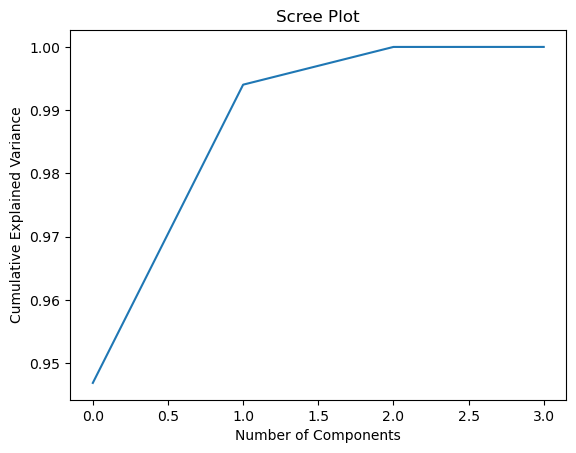

In [29]:
data_scaled=data_[['PCI','TCI','HCI','VCI']].values

# Apply PCA
pca = PCA()
pca.fit(data_scaled)

# Create scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [30]:
pca = PCA(n_components=1)  # Reduce to one dimension
# Fit and transform the data
X_reduced = pca.fit_transform(data_scaled)
print(X_reduced)

[[-0.32776335]
 [-0.25860738]
 [-0.17927768]
 ...
 [ 0.04235179]
 [ 0.04712262]
 [-0.02391387]]


In [31]:
data_['PC1']=X_reduced[:,0]

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split


X, y = data_[['PC1']], data_['pdsi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_reg = GradientBoostingRegressor()

# Define parameter grid for cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Print best parameters and cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_) 

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 8.111390043893053


In [33]:
gb_reg_model=GradientBoostingRegressor(n_estimators=200,max_depth=3,learning_rate=0.01)

In [34]:
gb_reg_model.fit(X,y)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=200)

In [35]:
import pickle
with open('model_and_pca.pickle','wb') as file:
    pickle.dump({'model':gb_reg_model,'pca':pca},file)

In [89]:
ch_all_11_22=[]
rh_all_11_22=[]
t_all_11_22=[]
for i in range(2011,2023):
    ch_all_11_22.extend(dict_ch[i])
    rh_all_11_22.extend(dict_rh[i])
    t_all_11_22.extend(dict_t[i])
ch_all_11_22=np.array(ch_all_11_22)
rh_all_11_22=np.array(rh_all_11_22)
t_all_11_22=np.array(t_all_11_22)

In [90]:
ch_all_11_22.shape

(144, 38, 50)

In [91]:
start_date = datetime(2011, 1, 1)
end_date_a = datetime(2023, 1, 1)
months_a = months_between(start_date, end_date_a)
ndvi_cal=ndvi_mosaic[:months_a,:,:]
pdsi_cal=pdsi_mosaic[:months_a,:,:]

In [92]:
data_all_2011_2022=np.array([ch_all_11_22,rh_all_11_22,t_all_11_22,ndvi_cal,pdsi_cal])

In [93]:
data_all_2011_2022.shape

(5, 144, 38, 50)

In [94]:
## reformat ndvi
data_all_2011_2022[3,:,:,:]=np.where(data_all_2011_2022[3,:,:,:]==0, -9999,data_all_2011_2022[3,:,:,:])
data_all_2011_2022[3,:,:,:]=np.where(data_all_2011_2022[3,:,:,:]==-9999, np.nan,data_all_2011_2022[3,:,:,:])*0.0001

##reformat pdsi
data_all_2011_2022[4,:,:,:]=np.where(data_all_2011_2022[4,:,:,:]==0, -9999,data_all_2011_2022[4,:,:,:])
data_all_2011_2022[4,:,:,:]=np.where(data_all_2011_2022[4,:,:,:]==-9999, np.nan,data_all_2011_2022[4,:,:,:])

##reformat ch
data_all_2011_2022[0,:,:,:]=np.where(data_all_2011_2022[0,:,:,:]==-9999, np.nan,data_all_2011_2022[0,:,:,:])

##reformat rh
data_all_2011_2022[1,:,:,:]=np.where(data_all_2011_2022[1,:,:,:]==-9999, np.nan,data_all_2011_2022[1,:,:,:])

##reformat t
data_all_2011_2022[2,:,:,:]=np.where(data_all_2011_2022[2,:,:,:]==-9999, np.nan,data_all_2011_2022[2,:,:,:])

In [95]:
data_index=data_all_2011_2022[:4,:,:,:].copy()

In [96]:
dict_index={
    'vci':{'min':-1,'max':1},
    'hci':{'min':min_value_rh.values,'max':max_value_rh.values},
    'pci':{'min':min_value_ch.values,'max':max_value_ch.values},
    'tci':{'min':min_value_t.values,'max':max_value_t.values}    
}

In [97]:
def calculate(arr,index):
    min=dict_index[index]['min']
    max=dict_index[index]['max']
    if arr==np.nan:
        return 0
    else:
        return (arr-min)/(max-min)

In [98]:
vec_func = np.vectorize(calculate)

In [99]:
pci_index=vec_func(data_all_2011_2022[0,:,:,:],index='pci')
hci_index=vec_func(data_all_2011_2022[1,:,:,:],index='hci')
tci_index=vec_func(data_all_2011_2022[2,:,:,:],index='tci')
vci_index=vec_func(data_all_2011_2022[3,:,:,:],index='vci')

In [100]:
import pickle
with open('index_pre_drought.pickle','wb') as file:
    pickle.dump({'pci':pci_index,
                 'hci':hci_index,
                 'tci':tci_index,
                 'vci':vci_index},file)

In [86]:
reference_raster = rxr.open_rasterio('Curah_Hujan.tif')

# Get the spatial properties from the reference raster
transform = reference_raster.rio.transform()
width, height = reference_raster.rio.width, reference_raster.rio.height
crs = reference_raster.rio.crs

with rasterio.open(
    'contoh.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(hci_index[0,:,:],1)

In [104]:
pci_index_c=np.nan_to_num(pci_index, nan=0)
tci_index_c=np.nan_to_num(tci_index, nan=0)
hci_index_c=np.nan_to_num(hci_index, nan=0)
vci_index_c=np.nan_to_num(vci_index, nan=0)

In [106]:
data_combine_gab=np.array([pci_index_c,tci_index_c,hci_index_c,vci_index_c])

In [115]:
sha_=data_combine_gab.shape
pc_dt=np.zeros((sha_[1],sha_[2],sha_[3]))
for i in tqdm((range(0,sha_[1]))):
    for j in range(0,sha_[2]):
        for k in range(0,sha_[3]):
            pc_dt[i,j,k]=pca.transform(data_combine_gab[:,i,j,k].reshape(1, -1))

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:25<00:00,  5.59it/s]


In [117]:
drought_index=np.zeros((sha_[1],sha_[2],sha_[3]))
for i in tqdm((range(0,sha_[1]))):
    for j in range(0,sha_[2]):
        for k in range(0,sha_[3]):
            drought_index[i,j,k]=gb_reg_model.predict(pc_dt[i,j,k].reshape(1, -1))

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [01:15<00:00,  1.90it/s]


In [121]:
pci_index[-60:,:,:].shape

(60, 38, 50)

In [122]:
reference_raster = rxr.open_rasterio('Curah_Hujan.tif')

# Get the spatial properties from the reference raster
transform = reference_raster.rio.transform()
width, height = reference_raster.rio.width, reference_raster.rio.height
crs = reference_raster.rio.crs

# Create a new multi-band raster dataset
with rasterio.open(
    'pci_20_22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=60,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    for i in range(0,60):
        dst.write(pci_index[-60+i,:,:].astype(rasterio.float32), i+1)

In [123]:
with rasterio.open(
    'vci_20_22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=60,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    for i in range(0,60):
        dst.write(vci_index[-60+i,:,:].astype(rasterio.float32), i+1)

In [124]:
with rasterio.open(
    'Output/hci_20_22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=60,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    for i in range(0,60):
        dst.write(hci_index[-60+i,:,:].astype(rasterio.float32), i+1)

In [164]:
with rasterio.open(
    'Output/tci_20_22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=60,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    for i in range(0,60):
        dst.write(tci_index[-60+i,:,:].astype(rasterio.float32), i+1)

In [ ]:
with rasterio.open(
    'Output/pc_20_22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=60,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    for i in range(0,60):
        dst.write(pc_dt[-60+i,:,:].astype(rasterio.float32), i+1)

In [127]:
with rasterio.open(
    'drought_20_22.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=60,
    dtype=rasterio.float32,
    crs=crs,
    transform=transform,
) as dst:
    for i in range(0,60):
        dst.write(drought_index[-60+i,:,:].astype(rasterio.float32), i+1)

In [163]:
import pickle
with open('Output/drought_array.pickle','wb') as file:
    pickle.dump(drought_index,file)

In [130]:
drought_index.shape

(144, 38, 50)

In [136]:
sh_=drought_index.shape
drought_span=np.zeros((sh_[0],64,64))

In [138]:
drought_span[:,:sh_[1],:sh_[2]]=drought_index

In [142]:
inputs = np.random.rand(100, 5)

In [159]:
sh=drought_span.shape
input_=3
output_=1
inputs=[]
outputs=[]
for i in range(sh[0]-input_):
    input_temp=drought_span[i:i+input_,:,:]
    inputs.append(input_temp)
    output_temp=drought_span[i+input_,:,:]
    outputs.append(output_temp)

In [162]:
with open('Output/array_forconvlstm.pickle','wb') as file:
    pickle.dump({'input':inputs,'output':outputs},file)